In [30]:
# Example from: https://www.geeksforgeeks.org/house-price-prediction-using-machine-learning-in-python/

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_csv("HousePricePrediction.csv")

# Printing first 5 records of the dataset
dataset.head(5)

,MSSubClass,MSZoning,LotArea,LotConfig,BldgType,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,BsmtFinSF2,TotalBsmtSF,SalePrice
0,60,RL,8450,Inside,1Fam,5,2003,2003,VinylSd,0.0,856.0,208500.0
1,20,RL,9600,FR2,1Fam,8,1976,1976,MetalSd,0.0,1262.0,181500.0
2,60,RL,11250,Inside,1Fam,5,2001,2002,VinylSd,0.0,920.0,223500.0
3,70,RL,9550,Corner,1Fam,5,1915,1970,Wd Sdng,0.0,756.0,140000.0
4,60,RL,14260,FR2,1Fam,5,2000,2000,VinylSd,0.0,1145.0,250000.0


In [4]:
dataset.shape

(2919, 12)

In [5]:
obj = (dataset.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))

int_ = (dataset.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))

fl = (dataset.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))

Categorical variables: 4
Integer variables: 5
Float variables: 3


<Axes: >

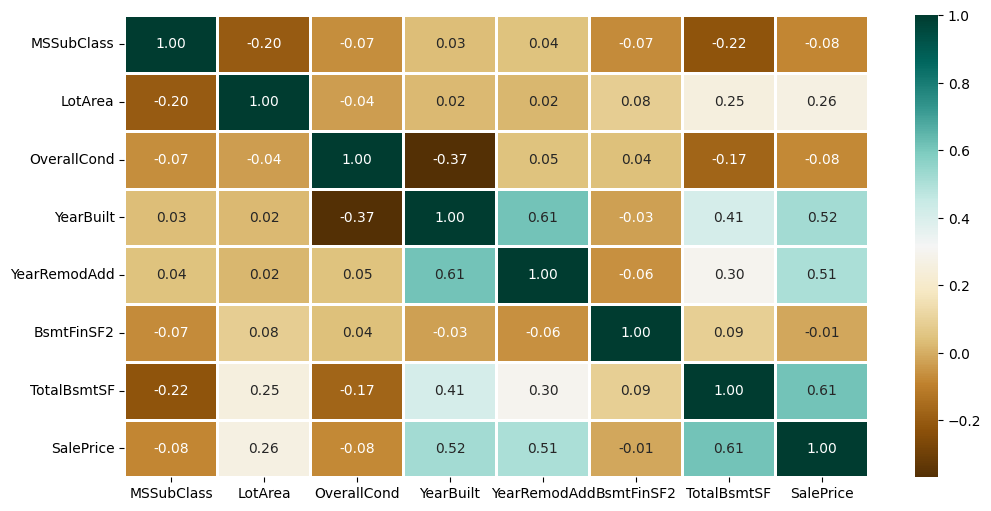

In [6]:
# Select only numerical features for correlation analysis
numerical_dataset = dataset.select_dtypes(include=['number'])

plt.figure(figsize=(12, 6))
sns.heatmap(numerical_dataset.corr(),
            cmap = 'BrBG',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

<Axes: title={'center': 'No. Unique values of Categorical Features'}>

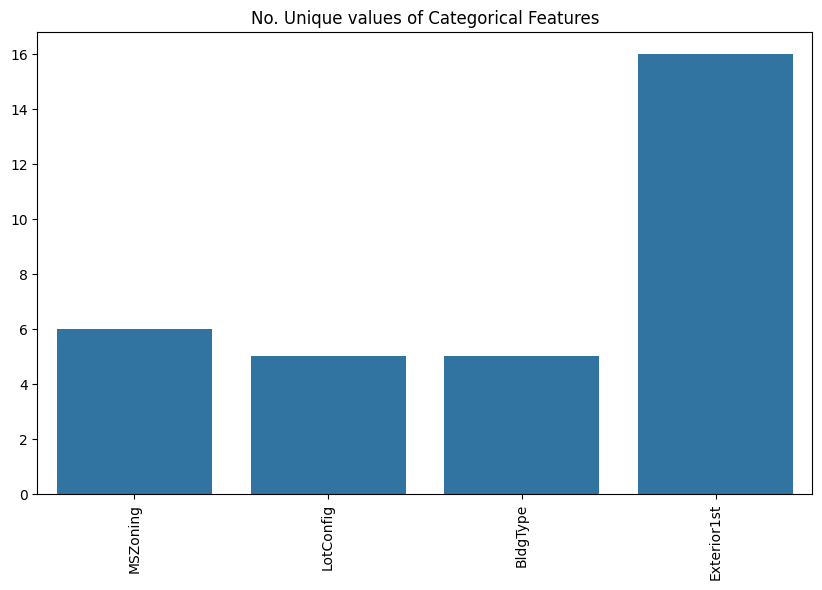

In [7]:
unique_values = []
for col in object_cols:
  unique_values.append(dataset[col].unique().size)
plt.figure(figsize=(10,6))
plt.title('No. Unique values of Categorical Features')
plt.xticks(rotation=90)
sns.barplot(x=object_cols,y=unique_values)

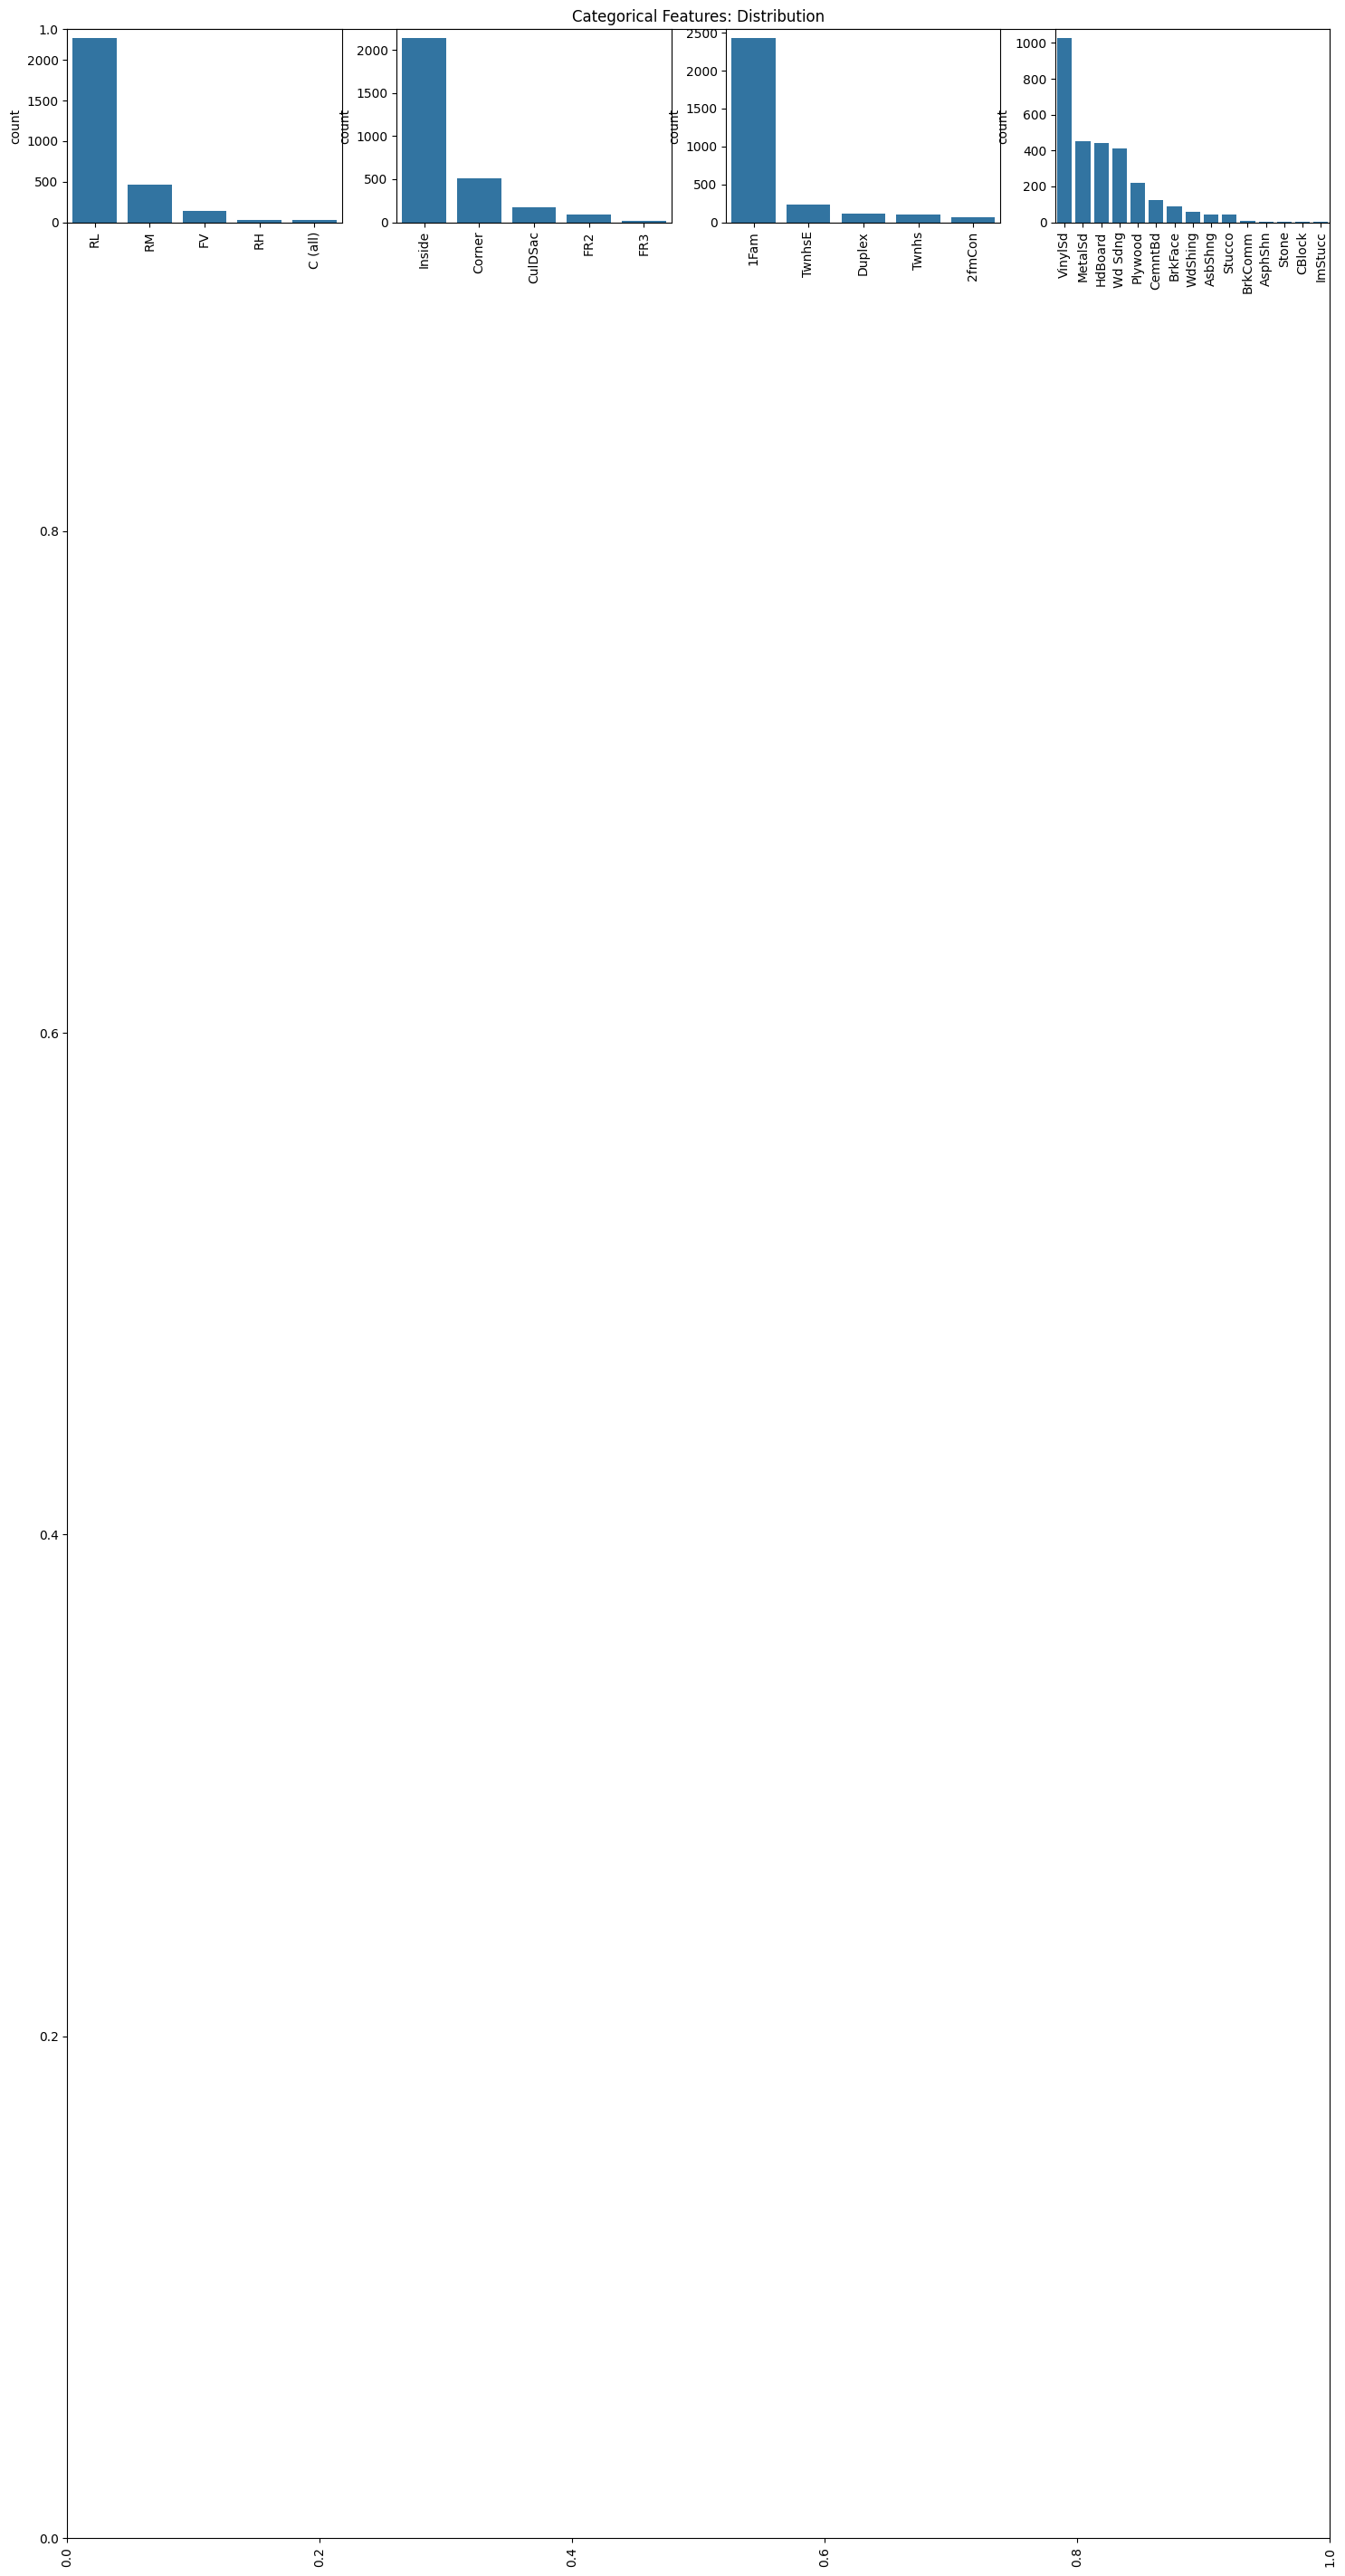

In [16]:
plt.figure(figsize=(18, 36))
plt.title('Categorical Features: Distribution')
plt.xticks(rotation=90)
index = 1

for col in object_cols:
    y = dataset[col].value_counts()
    plt.subplot(11, 4, index)
    plt.xticks(rotation=90)
    sns.barplot(x=list(y.index), y=y)
    index += 1

In [9]:
dataset['SalePrice'] = dataset['SalePrice'].fillna(
dataset['SalePrice'].mean())

In [10]:
new_dataset = dataset.dropna()

In [11]:
new_dataset.isnull().sum()

MSSubClass      0
MSZoning        0
LotArea         0
LotConfig       0
BldgType        0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
Exterior1st     0
BsmtFinSF2      0
TotalBsmtSF     0
SalePrice       0
dtype: int64

In [12]:
from sklearn.preprocessing import OneHotEncoder

s = (new_dataset.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)
print('No. of. categorical features: ',
    len(object_cols))

Categorical variables:
['MSZoning', 'LotConfig', 'BldgType', 'Exterior1st']
No. of. categorical features:  4


In [34]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(new_dataset[object_cols]))
OH_cols.index = new_dataset.index
OH_cols.columns = OH_encoder.get_feature_names_out()
df_final = new_dataset.drop(object_cols, axis=1)
df_final = pd.concat([df_final, OH_cols], axis=1)
df_final.rename(columns={'MSZoning_C (all)': 'MSZoning_C_all', 'Exterior1st_Wd Sdng': 'Exterior1st_Wd_Sdng'}, inplace=True)

In [36]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X = df_final.drop(['SalePrice'], axis=1)
Y = df_final['SalePrice']

# Split the training set into
# training and validation set
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X, Y, train_size=0.8, test_size=0.2, random_state=0)

In [37]:
from sklearn.metrics import mean_absolute_percentage_error

In [38]:
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression()
model_LR.fit(X_train, Y_train)
Y_pred = model_LR.predict(X_valid)

print(mean_absolute_percentage_error(Y_valid, Y_pred))

0.18741683841599896


In [39]:
from sklearn import svm
from sklearn.svm import SVC

model_SVR = svm.SVR()
model_SVR.fit(X_train,Y_train)
Y_pred = model_SVR.predict(X_valid)

print(mean_absolute_percentage_error(Y_valid, Y_pred))

0.1870512931870423


In [40]:
from sklearn.ensemble import RandomForestRegressor

model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train, Y_train)
Y_pred = model_RFR.predict(X_valid)

print(mean_absolute_percentage_error(Y_valid, Y_pred))

0.18394555147605413


### Persist Best Model

In [41]:
import pickle
import json

In [52]:
model_path = '../docker/model/best_model.pickle'

In [53]:
# model persisting
model = model_RFR
with open(model_path, 'wb') as fout:
    pickle.dump(model, fout, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
# model loading
model = None
with open(model_path, 'rb') as fin:
    model = pickle.load(fin)

In [55]:
# model inference
Y_pred = model.predict(X_valid)

In [56]:
# export
idx = 12

In [57]:
print('input:', json.dumps(X_valid.iloc[[idx]].to_dict('records'), indent=4))

input: [
    {
        "MSSubClass": 50,
        "LotArea": 8064,
        "OverallCond": 7,
        "YearBuilt": 1948,
        "YearRemodAdd": 1994,
        "BsmtFinSF2": 0.0,
        "TotalBsmtSF": 864.0,
        "MSZoning_C_all": 0.0,
        "MSZoning_FV": 0.0,
        "MSZoning_RH": 0.0,
        "MSZoning_RL": 1.0,
        "MSZoning_RM": 0.0,
        "LotConfig_Corner": 1.0,
        "LotConfig_CulDSac": 0.0,
        "LotConfig_FR2": 0.0,
        "LotConfig_FR3": 0.0,
        "LotConfig_Inside": 0.0,
        "BldgType_1Fam": 1.0,
        "BldgType_2fmCon": 0.0,
        "BldgType_Duplex": 0.0,
        "BldgType_Twnhs": 0.0,
        "BldgType_TwnhsE": 0.0,
        "Exterior1st_AsbShng": 0.0,
        "Exterior1st_AsphShn": 0.0,
        "Exterior1st_BrkComm": 0.0,
        "Exterior1st_BrkFace": 0.0,
        "Exterior1st_CBlock": 0.0,
        "Exterior1st_CemntBd": 0.0,
        "Exterior1st_HdBoard": 0.0,
        "Exterior1st_ImStucc": 0.0,
        "Exterior1st_MetalSd": 1.0,
        "Ex

In [58]:
print('prediction:', Y_pred[idx])

prediction: 167194.83712328767
